# Lab 10: Fully Connected Neural Networks

In this assignment, we will learn fully connected neural network. 


## 1. Example

This assignement should be run on Google Colab where you can use free GPU to accelerate the computation. Please refer to our slides to set up GPU. 

[![Open In Colab][colab badge]][colab]

[colab badge]: https://colab.research.google.com/assets/colab-badge.svg
[colab]: https://colab.research.google.com/github/lduran2/CIS3715_DataScience_2022/blob/lab10/Lab10/Lab10.ipynb

### 1. Install Pytorch

In [ ]:
!pip3 install torch torchvision   # install pytorch

### 2. Check GPU

In [ ]:
!/opt/bin/nvidia-smi  #show GPU 

Sun Apr 10 03:04:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### 3. Mount to google drive (optional)

In [ ]:

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### 4. Code

In [ ]:
#Import Libraries
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pandas as pd
from math import *

In [ ]:
args={}
args['batch_size']=100
args['test_batch_size']=100
args['epochs']=10  #The number of Epochs is the number of times you go through the full dataset. 
args['lr']=0.01 #Learning rate is how fast it will decend. 
args['log_interval']=10

In [ ]:
def seed_rnd(a_seed):
    '''
    Seeds all relevant RND libaries.
    '''
    # import and seed numpy if unused
    import numpy
    numpy.random.seed(a_seed)
    # seed Pytorch
    torch.manual_seed(a_seed)
    # seed the GPU(s)
    torch.cuda.manual_seed_all(a_seed)
# end seed_rnd(a_seed)

In [ ]:
# use a constant random seed to make experiment repeatable
seed_rnd(42)

The model will be added to GPU when it will be trained/tested with each other model.

The number of layers `N_LAYERS` abstracted from the Net model.
The number of nodes per layer works in a way that the first layer has $28\times28$ nodes,
the last has $10$ nodes.
This is the case for $1$ layer.
Then the middle layers with $256$ nodes and $128$ nodes are each added in order.
As more layers are added,
they are added with a bias towards the input layer.
After $3$ layers,
the new hidden layers will
take equidistant geometric steps
from the middle layers to the outer layers.

In [ ]:
#build an mlp,
#defaults to 3 layers, but can be changed with N_LAYERS
class Net(nn.Module):

    #the predefined nodes
    __N_NODES_FIRST = 28*28
    __N_NODES_LAST = 10
    #logs of nodes
    __LOG_N_NODES_PREMID = log(256)
    __LOG_N_NODES_POSTMID = log(128)
    __LOG_N_NODES_FIRST = log(__N_NODES_FIRST)
    __LOG_N_NODES_LAST = log(__N_NODES_LAST)

    def __init__(self, N_LAYERS=3):
        super(Net, self).__init__()

        #total nodes
        N_NODES = (N_LAYERS + 1)
        #number nodes from middle
        N_PREMID = (N_NODES + 1)//2
        N_POSTMID = (N_NODES - N_PREMID)

        #create the additional nodes from center
        nodes_premid = tuple(
            int(round(
                exp((
                    (N_PREMID - k)*Net.__LOG_N_NODES_PREMID
                    + k*Net.__LOG_N_NODES_FIRST
                )/N_PREMID)
            )) for k in range(N_PREMID - 1))
        nodes_postmid = tuple(
            int(round(
                exp((
                    (N_POSTMID - k)*Net.__LOG_N_NODES_POSTMID
                    + k*Net.__LOG_N_NODES_LAST
                )/N_POSTMID)
            )) for k in range(N_POSTMID - 1))
        #combine first, premid, postmid, last, reversing premid
        nodes = (Net.__N_NODES_FIRST,) + nodes_premid[::-1]
        nodes += nodes_postmid + (Net.__N_NODES_LAST,)

        #create a list of linear modules from nodes[i] to nodes[i+1]
        #for all i in [0, len(nodes))
        # see https://pytorch.org/docs/0.4.1/nn.html#torch.nn.ModuleList
        self.fc1 = nn.ModuleList(nn.Linear(el, nodes[idx+1])
            for idx, el in enumerate(nodes[:-1]))

    def forward(self, x):
        h0 = x.view(-1,28*28)   #input layer

        h1 = h0 #hidden layers, start with input
        for fc in self.fc1[:-1]:
            h1 = F.relu(fc(h1)) #apply next hidden layer

        h2 = self.fc1[-1](h1)   #output layer

        return h2

# make a default net for later analysis
model = Net()
print(model)

Net(
  (fc1): ModuleList(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)


The optimizer was moved down to the train/test loop
because it needs to be updated for each model.

In [ ]:
# loss function
criterion = nn.CrossEntropyLoss()

In [ ]:
#load the data
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['batch_size'], shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['test_batch_size'], shuffle=False)

## 2. Tasks

I have changed the `train` and `test` functions
and added some of my own to make it possible to aggregate loss and accuracy.

#### `train` and its callbacks

In [ ]:
def printTrainReport(epoch, i_xamp, N_XAMPS, pc_accuracy, r_loss):
    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, i_xamp, N_XAMPS, pc_accuracy, r_loss))
# end def printTrainReport(epoch, i_xamp, N_XAMPS, pc_accuracy, r_loss)

In [ ]:
def createAppendLossTo(queue):
    def appendLossToQueue(epoch, i_xamp, N_XAMPS, pc_accuracy, r_loss):
        queue.append(r_loss)
    # end def appendLossToQueue(epoch, i_xamp, N_XAMPS, pc_accuracy, r_loss)
    return appendLossToQueue
# end def createAppendLossTo(queue)(epoch, i_xamp, N_XAMPS, pc_accuracy, r_loss)

In [ ]:
def train(epoch, callbacks=[printTrainReport]):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        
        output = model(data)
        loss = criterion(output, target)

        # compute gradients
        optimizer.zero_grad()
        loss.backward()

        #to do a one-step update on our parameter.
        optimizer.step()

        #Apply callbacks to the loss periodically. 
        if batch_idx % args['log_interval'] == 0:
            for callback in callbacks:
                callback(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item())

#### `test` and its callbacks

In [ ]:
def printTestReport(epoch, r_test_loss, N_CORRECTS, N_XAMPS, pc_accuracy):
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
        .format(r_test_loss, N_CORRECTS, N_XAMPS, pc_accuracy))
# end def printTestReport(epoch, r_test_loss, N_CORRECTS, N_XAMPS, pc_accuracy)

In [ ]:
def createAppendAccuracyTo(queue):
    def appendAccuracyToQueue(
          epoch, r_test_loss, N_CORRECTS, N_XAMPS, pc_accuracy):
        queue.append(pc_accuracy)
    # end def appendAccuracyToQueue(
    #     epoch, r_test_loss, N_CORRECTS, N_XAMPS, pc_accuracy)
    return appendAccuracyToQueue
# end def createAppendAccuracyTo(queue)(
#     epoch, r_test_loss, N_CORRECTS, N_XAMPS, pc_accuracy)

In [ ]:
def test(epoch=-1, callbacks=[printTestReport]):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = data.cuda(), target.cuda()

        output = model(data)
        test_loss += criterion(output, target).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] 
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

    test_loss /= len(test_loader.dataset)

    for callback in callbacks:
        callback(
            epoch, test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset))

### 1. Please use other activation functions, e.g., sigmoid, tanh, and then plot the training loss and testing accuracy. 

When plotting the training loss, the x-axis is iteration and the y-axis is training loss. When plotting the testing accuracy,  the x-axis is epoch and the y-axis is the training loss.

#### activation functions

In [ ]:
#a test value for testing activation functions
test_s = torch.Tensor([[-1, 0, 1], [-2, 0, 2], [1, 0, 1]])
print(test_s)

tensor([[-1.,  0.,  1.],
        [-2.,  0.,  2.],
        [ 1.,  0.,  1.]])


In [ ]:
def sigmoid(s):
    return 1/(1 + torch.exp(-s))
# end def sigmoid(s)

print(sigmoid(test_s))

tensor([[0.2689, 0.5000, 0.7311],
        [0.1192, 0.5000, 0.8808],
        [0.7311, 0.5000, 0.7311]])


In [ ]:
def tanh(s):
    '''
    Hyperbolic tangent.
    '''
    return (2*sigmoid(2*s) - 1)
# end def tanh(s)

print(tanh(test_s))

tensor([[-0.7616,  0.0000,  0.7616],
        [-0.9640,  0.0000,  0.9640],
        [ 0.7616,  0.0000,  0.7616]])


In [ ]:
def create_leaky_relu(alpha=1e-2):
    '''
    ReLU that leaks on negative input.
    @param alpha : float = negative slope
    '''
    def leaky_relu(s):
        return torch.max(alpha*s, s)
    # end def leaky_relu(s)
    return leaky_relu
# end def create_leaky_relu(alpha=1e-2)(s)

# get a default leaky ReLU
leaky_relu = create_leaky_relu()

print(leaky_relu(test_s))

tensor([[-0.0100,  0.0000,  1.0000],
        [-0.0200,  0.0000,  2.0000],
        [ 1.0000,  0.0000,  1.0000]])


In [ ]:
# the original Re(ctified) L(inear) U(nit)
# relu = -0. if s = 0
relu = create_leaky_relu(alpha=-0.)

print(relu(test_s))

tensor([[0., -0., 1.],
        [0., -0., 2.],
        [1., -0., 1.]])


In [ ]:
def create_elu(alpha=1.):
    '''
    E(xponential)=L(inear) U(nit).
    @param alpha : float = negative coefficient
    '''
    def elu(s):
        return (s + (-s + alpha*(torch.exp(s) - 1))*(s <= 0))
    # end def elu(s)
    return elu
# end def create_elu(alpha=1.)(s)

# get a default ELU
elu = create_elu()

print(elu(test_s))

tensor([[-0.6321,  0.0000,  1.0000],
        [-0.8647,  0.0000,  2.0000],
        [ 1.0000,  0.0000,  1.0000]])


In [ ]:
def testTensorOrientation():
    #show the Pandas data frame
    import pandas as pd
    print('===Pandas data frame===')
    print(pd.DataFrame({'a': [1, 2], 'b': [3, 4]})**2)
    # show the Pytorch tensor
    print('===Pytorch tensor===')
    print(torch.Tensor([[1, 2], [3, 4]])**2)
# end def testTensors()

testTensorOrientation()

===Pandas data frame===
   a   b
0  1   9
1  4  16
===Pytorch tensor===
tensor([[ 1.,  4.],
        [ 9., 16.]])


In the previous cell,
we see that `pandas` data frames are oriented by column
whereas Pytorch tensors are oriented by row instead.

In [ ]:
def softmax(s):
    '''
    For each column, each cell is
        exp(s)/sum(exp(s)).
    '''
    # sum along axis=1, which is by rows
    norm = torch.sum(torch.exp(s), 1)
    # we reshape to a column vector of norms
    norm_cols = norm.reshape(-1,1)
    return torch.exp(s)/norm_cols
# end def softmax(s)

print(softmax(test_s))

tensor([[0.0900, 0.2447, 0.6652],
        [0.0159, 0.1173, 0.8668],
        [0.4223, 0.1554, 0.4223]])


#### Create the activation models.

In [ ]:
# create a list of models
models = [model]
# model names
model_names = ['Net']

In [ ]:
# activation functions
activates = (sigmoid, tanh, relu, leaky_relu, elu, softmax)
model_names += ('Sigmoid', 'tanh', 'ReLU', 'Leaky ReLU', 'ELU', 'softmax')

In [ ]:
# build an mlp that uses a specific activation function
class Activation(nn.Module):
    def __init__(self, activate):
        super(Activation, self).__init__()
        
        self.fc1 = nn.Linear(28*28, 256)   # linear layer (784 -> 256)
        self.fc2 = nn.Linear(256,128)  # linear layer (256 -> 128)
        self.fc3 = nn.Linear(128,10)  # linear layer (128 -> 10)

        self.activate = activate

    def forward(self, x):
        h0 = x.view(-1,28*28) #input layer
        h1 = self.activate(self.fc1(h0)) # hidden layer 1
        h2 = self.activate(self.fc2(h1)) # hidden layer 2
        h3 = self.activate(self.fc3(h2)) # output layer

        return h3
# end class Activation(nn.Module)

In [ ]:
#create the activation function models
for activate in activates:
    models.append(Activation(activate))

#print the last (activation) model
# all activation models will look identical as strings
# because they use the same layer patterns as Net()
# (28*28,256)->(256,128)->(128,10)
print(models[-1])

Activation(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


#### Train and test each model.

In [ ]:
#dictionaries for model to losses, accuracies.
loss_dict = {}
accuracy_dict = {}

for model, name in zip(models, model_names):
    #Create callback for appending losses.
    loss_dict[name] = []
    appendLoss = createAppendLossTo(loss_dict[name])
    #Create callback for appending accuracies.
    accuracy_dict[name] = []
    appendAccuracy = createAppendAccuracyTo(accuracy_dict[name])

    # put the model on GPU
    model.cuda() 
    # add optimizer
    optimizer = torch.optim.SGD(model.parameters(),lr = args['lr'])

    #loop through epoches.
    for epoch in range(1, args['epochs'] + 1):
        #name the model
        print("======{}======".format(name))
        print()

        train(epoch, callbacks=(printTrainReport, appendLoss))
        test(epoch, callbacks=(printTestReport, appendAccuracy))

    print()

#create data frames from maps
losses = pd.DataFrame(loss_dict)
accuracies = pd.DataFrame(accuracy_dict)

#### Results

In [ ]:
losses

,Net,Sigmoid,tanh,ReLU,Leaky ReLU,ELU,softmax
0,2.306634,2.311714,2.299449,2.300189,2.307920,2.322921,2.302845
1,2.283218,2.302422,2.208156,2.298090,2.301759,2.210531,2.302926
2,2.243291,2.310896,2.137013,2.287618,2.276855,2.111069,2.302499
3,2.219450,2.305600,2.058062,2.266883,2.286099,1.986740,2.303159
4,2.197454,2.310975,1.985349,2.234091,2.253999,1.906855,2.303546
...,...,...,...,...,...,...,...
595,0.165749,2.242955,0.924875,0.296563,0.122687,0.083958,2.302538
596,0.134152,2.242059,0.955777,0.495033,0.274634,0.224462,2.302555
597,0.087051,2.248285,0.926128,0.455808,0.126563,0.177504,2.301789
598,0.228055,2.251299,0.936369,0.449051,0.113192,0.175131,2.303403


In [ ]:
accuracies

,Net,Sigmoid,tanh,ReLU,Leaky ReLU,ELU,softmax
0,tensor(88.7500),tensor(11.3500),tensor(87.7800),tensor(79.3400),tensor(72.0300),tensor(89.3800),tensor(8.9200)
1,tensor(90.9700),tensor(11.3500),tensor(89.9600),tensor(82.0900),tensor(90.0800),tensor(91.1600),tensor(10.2800)
2,tensor(92.4200),tensor(11.3500),tensor(91.1300),tensor(83.2900),tensor(91.9800),tensor(91.9600),tensor(10.2800)
3,tensor(92.9100),tensor(11.3500),tensor(91.5600),tensor(83.9700),tensor(92.8200),tensor(92.4500),tensor(10.2800)
4,tensor(93.6200),tensor(11.3600),tensor(91.9800),tensor(84.5400),tensor(93.4800),tensor(92.8900),tensor(10.2800)
5,tensor(94.1100),tensor(12.6900),tensor(92.2400),tensor(84.8400),tensor(94.2000),tensor(93.0900),tensor(10.2800)
6,tensor(94.4300),tensor(17.0900),tensor(92.6100),tensor(85.3700),tensor(94.5700),tensor(93.4800),tensor(10.2800)
7,tensor(94.8400),tensor(22.7600),tensor(92.9700),tensor(85.6600),tensor(95.0100),tensor(93.8900),tensor(10.2800)
8,tensor(95.1500),tensor(29.5100),tensor(93.1100),tensor(86.0300),tensor(95.3900),tensor(94.2900),tensor(11.3500)
9,tensor(95.4800),tensor(39.9400),tensor(93.4200),tensor(86.2000),tensor(95.6800),tensor(94.4700),tensor(11.3500)


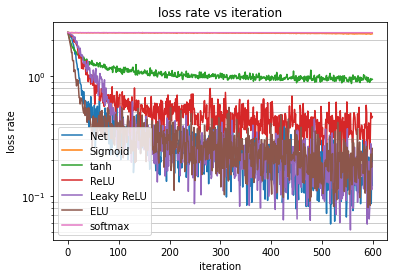

In [ ]:
# difference in loss is not as significant at higher magnitudes, so semilogy
N_ITERATIONS = losses.shape[0]
iterations_lin = torch.Tensor(range(N_ITERATIONS))
# plot the loss
fig, ax = plt.subplots(1, 1)
ax.semilogy(iterations_lin, losses)
ax.set_title('loss rate vs iteration')
ax.set_xlabel('iteration')
ax.set_ylabel('loss rate')
ax.legend(model_names)
ax.grid(color='silver', which='minor', axis='y', linestyle='solid')
fig.show()

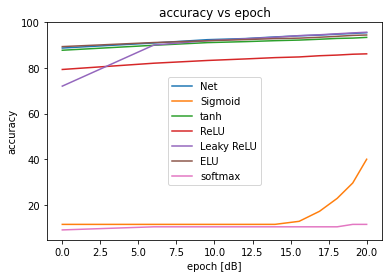

In [ ]:
# we will plot with dB on x.
# this linearizes for the Net model
N_EPOCHS = accuracies.shape[0]
epoch_lin = torch.Tensor(range(1, (N_EPOCHS + 1)))
epoch_db = 20*torch.log10(epoch_lin)
# plot the accuracy
fig, ax = plt.subplots(1, 1)
ax.plot(epoch_db, accuracies)
ax.set_title('accuracy vs epoch')
ax.set_xlabel('epoch [dB]')
ax.set_ylabel('accuracy')
ax.legend(model_names)
fig.show()

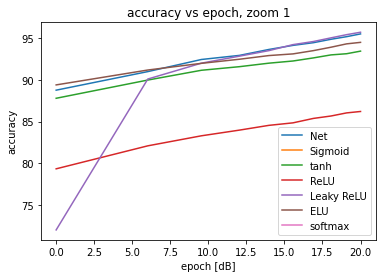

In [ ]:
# we will plot with dB on x.
# this linearizes for the Net model
N_EPOCHS = accuracies.shape[0]
epoch_lin = torch.Tensor(range(1, (N_EPOCHS + 1)))
epoch_db = 20*torch.log10(epoch_lin)
# plot the accuracy
fig, ax = plt.subplots(1, 1)
ax.plot(epoch_db, accuracies)
ax.set_title('accuracy vs epoch, zoom 1')
ax.set_xlabel('epoch [dB]')
ax.set_ylabel('accuracy')
ax.legend(model_names)
#zoom in to exclude low-accuracy Sigmoid and softmax
accuracies_zoom = accuracies.drop(['Sigmoid', 'softmax'], axis=1)
zoom_min = accuracies_zoom.min().min()
zoom_max = accuracies_zoom.max().max()
#add about 1/10 margin
zoom_range = (zoom_max - zoom_min)
zoom_min -= zoom_range/20
zoom_max += zoom_range/20
ax.set_ylim((zoom_min, zoom_max))
fig.show()

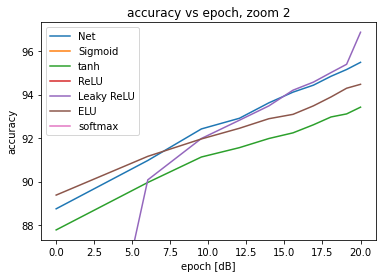

In [ ]:
# we will plot with dB on x.
# this linearizes for the Net model
N_EPOCHS = accuracies.shape[0]
epoch_lin = torch.Tensor(range(1, (N_EPOCHS + 1)))
epoch_db = 20*torch.log10(epoch_lin)
# plot the accuracy
fig, ax = plt.subplots(1, 1)
ax.plot(epoch_db, accuracies)
ax.set_title('accuracy vs epoch, zoom 2')
ax.set_xlabel('epoch [dB]')
ax.set_ylabel('accuracy')
ax.legend(model_names)
#zoom further in to exclude mid-accuracy ReLU, part of Leaky ReLU
accuracies_zoom2 = accuracies_zoom.drop(['ReLU', 'Leaky ReLU'], axis=1)
zoom_min = accuracies_zoom2.min().min()
#for max, we can use the previous zoom
zoom_max = accuracies_zoom.max().max()
#add about 1/10 margin
zoom_range = (zoom_max - zoom_min)
zoom_min -= zoom_range/20
zoom_max += zoom_range/20
zoom_max = min(zoom_max, 100)
ax.set_ylim((zoom_min, zoom_max))
fig.show()

### 2. Please use different layers in the model, e.g., 1 layer, 5 layers, 10 layers,  and then plot the training loss and testing accuracy.

#### Build models.

In [ ]:
models2 = [Net()]
model2_names = ['3 layers']
print(models2[-1])

Net(
  (fc1): ModuleList(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [ ]:
# build an mlp for 1, 5, 10 layers
nos_of_layers = (3, 1, 5, 10)
for N_LAYERS in nos_of_layers[1:]:
    models2.append(Net(N_LAYERS=N_LAYERS))
    model2_names.append("{} layer{}".format(N_LAYERS, '' if N_LAYERS==1 else 's'))
    print(models2[-1])
    print()

Net(
  (fc1): ModuleList(
    (0): Linear(in_features=784, out_features=10, bias=True)
  )
)

Net(
  (fc1): ModuleList(
    (0): Linear(in_features=784, out_features=372, bias=True)
    (1): Linear(in_features=372, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Linear(in_features=128, out_features=55, bias=True)
    (4): Linear(in_features=55, out_features=10, bias=True)
  )
)

Net(
  (fc1): ModuleList(
    (0): Linear(in_features=784, out_features=540, bias=True)
    (1): Linear(in_features=540, out_features=448, bias=True)
    (2): Linear(in_features=448, out_features=372, bias=True)
    (3): Linear(in_features=372, out_features=308, bias=True)
    (4): Linear(in_features=308, out_features=256, bias=True)
    (5): Linear(in_features=256, out_features=128, bias=True)
    (6): Linear(in_features=128, out_features=77, bias=True)
    (7): Linear(in_features=77, out_features=46, bias=True)
    (8): Linear(in_features=46, out_features=28

#### Train and test the models.

In [ ]:
#dictionaries for model to losses, accuracies.
loss_dict = { }
accuracy_dict = { }

for model, name in zip(models2, model2_names):
    #Create callback for appending losses.
    loss_dict[name] = []
    appendLoss = createAppendLossTo(loss_dict[name])
    #Create callback for appending accuracies.
    accuracy_dict[name] = []
    appendAccuracy = createAppendAccuracyTo(accuracy_dict[name])

    # put the model on GPU
    model.cuda() 
    # add optimizer
    optimizer = torch.optim.SGD(model.parameters(),lr = args['lr'])

    #loop through epoches.
    for epoch in range(1, args['epochs'] + 1):
        #name the model
        print("======{}======".format(name))
        print()

        train(epoch, callbacks=(printTrainReport, appendLoss))
        test(epoch, callbacks=(printTestReport, appendAccuracy))

    print()

#create data frames from maps
losses2 = pd.DataFrame(loss_dict)
accuracies2 = pd.DataFrame(accuracy_dict)

#### Results

In [ ]:
losses2

,3 layers,1 layer,5 layers,10 layers
0,2.314373,2.448163,2.318138,2.318375
1,2.297947,1.541502,2.299002,2.319930
2,2.262665,1.246722,2.311305,2.310929
3,2.231296,0.967621,2.303021,2.311255
4,2.204319,0.929214,2.301808,2.311256
...,...,...,...,...
595,0.142093,0.378317,0.121955,2.301429
596,0.274319,0.303970,0.203190,2.295834
597,0.155842,0.413478,0.117099,2.301061
598,0.112624,0.248891,0.038835,2.298814


In [ ]:
accuracies2

,3 layers,1 layer,5 layers,10 layers
0,tensor(88.8500),tensor(90.2800),tensor(39.6500),tensor(11.3500)
1,tensor(91.2700),tensor(90.8800),tensor(85.5800),tensor(11.3500)
2,tensor(92.3200),tensor(91.4500),tensor(90.0800),tensor(11.3500)
3,tensor(93.2400),tensor(91.4900),tensor(91.5700),tensor(11.3500)
4,tensor(93.6700),tensor(91.6400),tensor(92.8200),tensor(11.3500)
5,tensor(94.3500),tensor(91.8300),tensor(93.9000),tensor(11.3500)
6,tensor(94.7700),tensor(91.8000),tensor(94.7200),tensor(11.3500)
7,tensor(95.2100),tensor(92.0300),tensor(95.3800),tensor(11.3500)
8,tensor(95.4600),tensor(91.9700),tensor(95.7000),tensor(11.3500)
9,tensor(95.8200),tensor(92.0200),tensor(96.0900),tensor(11.3500)


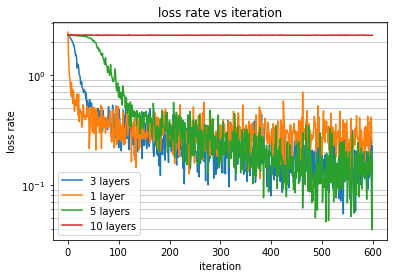

In [ ]:
# difference in loss is not as significant at higher magnitudes, so semilogy
N_ITERATIONS = losses2.shape[0]
iterations_lin = torch.Tensor(range(N_ITERATIONS))
# plot the loss
fig, ax = plt.subplots(1, 1)
ax.semilogy(iterations_lin, losses2)
ax.set_title('loss rate vs iteration')
ax.set_xlabel('iteration')
ax.set_ylabel('loss rate')
ax.legend(model2_names)
ax.grid(color='silver', which='minor', axis='y', linestyle='solid')
fig.show()

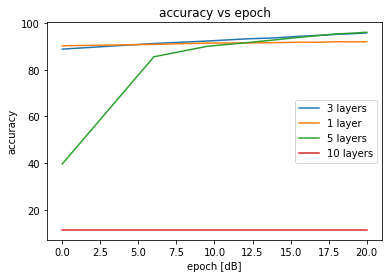

In [ ]:
# we will plot with dB on x.
# this linearizes for the Net model
epoch_lin = torch.Tensor(range(1, (len(accuracies2) + 1)))
epoch_db = 20*torch.log10(epoch_lin)
# plot the accuracy
fig, ax = plt.subplots(1, 1)
ax.plot(epoch_db, accuracies2)
ax.set_title('accuracy vs epoch')
ax.set_xlabel('epoch [dB]')
ax.set_ylabel('accuracy')
ax.legend(model2_names)
fig.show()

It is expected that $10$ layers will have low accuracy due to overfitting.
Such a perceptron may predict the training data with very high accuracy,
but the testing data would have a much lower accuracy.

Let's zoom into $3$ layers, $1$ layer,
and for $5$ layers with number of epochs $> 1 \approx 6\,\textrm{dB}$.

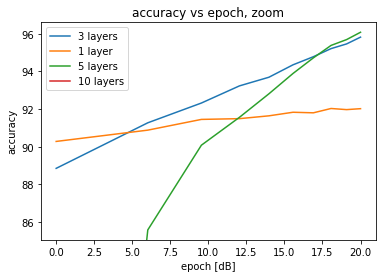

In [ ]:
# we will plot with dB on x.
# this linearizes for the Net model
epoch_lin = torch.Tensor(range(1, (len(accuracies2) + 1)))
epoch_db = 20*torch.log10(epoch_lin)
# plot the accuracy
fig, ax = plt.subplots(1, 1)
ax.plot(epoch_db, accuracies2)
ax.set_title('accuracy vs epoch, zoom')
ax.set_xlabel('epoch [dB]')
ax.set_ylabel('accuracy')
ax.legend(model2_names)
#zoom in to exclude low-accuracy 10 layers,
#and 5 layers after 6 dB ~ 1 epoch
accuracies2_zoom = accuracies2.drop(['10 layers'], axis=1)[1:]
zoom_min = accuracies2_zoom.min().min()
zoom_max = accuracies2_zoom.max().max()
#add about 1/10 margin
zoom_range = (zoom_max - zoom_min)
zoom_min -= zoom_range/20
zoom_max += zoom_range/20
zoom_max = min(zoom_max, 100)
ax.set_ylim((zoom_min, zoom_max))
fig.show()

##### Layer domain

Finally,
we observe the layer domain for each epoch.

In [ ]:
#transpose the losses
#rename indices to just the # of layers without unit
#sort by the number of layers
all_losses2_vs_layers = losses2.transpose().rename(index=dict(zip(model2_names, nos_of_layers))).sort_index()
all_losses2_vs_layers

,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
1,2.448163,1.541502,1.246722,0.967621,0.929214,0.754410,0.655783,0.855510,0.618936,0.741318,...,0.421770,0.226618,0.177951,0.299844,0.215855,0.378317,0.303970,0.413478,0.248891,0.241711
3,2.314373,2.297947,2.262665,2.231296,2.204319,2.171836,2.125569,2.085021,2.051248,1.999656,...,0.092429,0.091018,0.197973,0.115597,0.175924,0.142033,0.274126,0.155528,0.112567,0.226554
5,2.318138,2.299002,2.311305,2.303021,2.301808,2.302501,2.298676,2.309963,2.310081,2.298397,...,0.127327,0.199118,0.176577,0.134004,0.181359,0.122130,0.204267,0.116314,0.039070,0.169994
10,2.318375,2.319930,2.310929,2.311255,2.311256,2.321759,2.308670,2.319041,2.308111,2.303276,...,2.303041,2.296325,2.302777,2.289734,2.294533,2.301429,2.295834,2.301061,2.298814,2.297143


In [ ]:
#store 0 and end of each iteration
ITERATIONS_PER_EPOCH = N_ITERATIONS//args['epochs']
I_EPOCH_ITERS = [0,] + list(range(ITERATIONS_PER_EPOCH - 1, N_ITERATIONS, ITERATIONS_PER_EPOCH))
losses2_vs_layers = all_losses2_vs_layers[I_EPOCH_ITERS]
losses2_vs_layers

,0,59,119,179,239,299,359,419,479,539,599
1,2.448163,0.347116,0.347181,0.198327,0.331280,0.250038,0.354212,0.388182,0.286774,0.177847,0.241711
3,2.314373,0.496309,0.270805,0.149647,0.268505,0.222139,0.173861,0.248182,0.119980,0.084474,0.226554
5,2.318138,1.784680,0.508605,0.281133,0.286940,0.251100,0.149619,0.166543,0.147892,0.247681,0.169994
10,2.318375,2.316149,2.306584,2.300231,2.301946,2.300313,2.310112,2.312663,2.293694,2.309637,2.297143


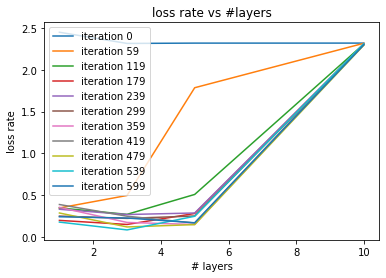

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.plot(losses2_vs_layers)
ax.set_title('loss rate vs #layers')
ax.set_xlabel('# layers')
ax.set_ylabel('loss rate')
ax.legend(tuple('iteration {}'.format(k) for k in I_EPOCH_ITERS))
fig.show()

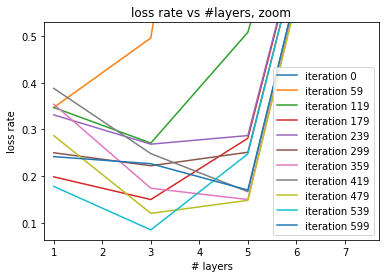

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.plot(losses2_vs_layers)
ax.set_title('loss rate vs #layers, zoom')
ax.set_xlabel('# layers')
ax.set_ylabel('loss rate')
ax.legend(tuple('iteration {}'.format(k) for k in I_EPOCH_ITERS))
#zoom in into > 2 layers
losses2_vs_layers_zoom = losses2_vs_layers[I_EPOCH_ITERS[2:]][:-1]
zoom_min = losses2_vs_layers_zoom.min().min()
zoom_max = losses2_vs_layers_zoom.max().max()
#add about 1/10 margin
zoom_range = (zoom_max - zoom_min)
zoom_min -= zoom_range/20
zoom_max += zoom_range/20
zoom_max = min(zoom_max, 100)
ax.set_ylim((zoom_min, zoom_max))
#ignore epoch 10 as well
ax.set_xlim((0.8, 7.7))
fig.show()

In [ ]:
#transpose the accuracies
#rename indices to just the # of layers without unit
#sort by the number of layers
accuracies2_vs_layers = accuracies2.transpose().rename(index=dict(zip(model2_names, nos_of_layers))).sort_index()
accuracies2_vs_layers

,0,1,2,3,4,5,6,7,8,9
1,tensor(90.2800),tensor(90.8800),tensor(91.4500),tensor(91.4900),tensor(91.6400),tensor(91.8300),tensor(91.8000),tensor(92.0300),tensor(91.9700),tensor(92.0200)
3,tensor(88.8500),tensor(91.2700),tensor(92.3200),tensor(93.2300),tensor(93.6900),tensor(94.3500),tensor(94.7800),tensor(95.2100),tensor(95.4600),tensor(95.8200)
5,tensor(39.6500),tensor(85.0550),tensor(90.0800),tensor(91.5600),tensor(92.8100),tensor(93.8900),tensor(94.7200),tensor(95.3800),tensor(95.6900),tensor(96.6050)
10,tensor(11.3500),tensor(11.3500),tensor(11.3500),tensor(11.3500),tensor(11.3500),tensor(11.3500),tensor(11.3500),tensor(11.3500),tensor(11.3500),tensor(11.3500)


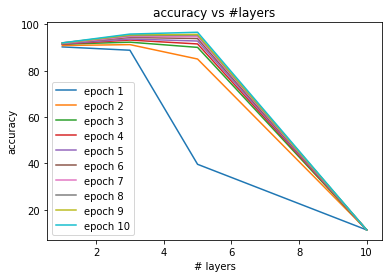

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.plot(accuracies2_vs_layers)
ax.set_title('accuracy vs #layers')
ax.set_xlabel('# layers')
ax.set_ylabel('accuracy')
ax.legend(tuple('epoch {}'.format(k + 1) for k in range(args['epochs'])))
fig.show()

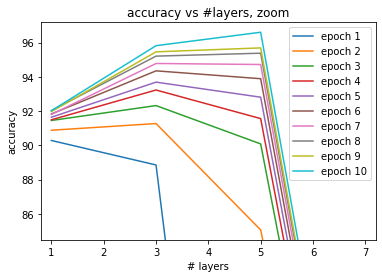

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.plot(accuracies2_vs_layers)
ax.set_title('accuracy vs #layers, zoom')
ax.set_xlabel('# layers')
ax.set_ylabel('accuracy')
ax.legend(tuple('epoch {}'.format(k + 1) for k in range(args['epochs'])))
#zoom in as with accuracy vs epochs, zoom, for layers
zoom_min = accuracies2_zoom.min().min()
zoom_max = accuracies2_zoom.max().max()
#add about 1/10 margin
zoom_range = (zoom_max - zoom_min)
zoom_min -= zoom_range/20
zoom_max += zoom_range/20
zoom_max = min(zoom_max, 100)
ax.set_ylim((zoom_min, zoom_max))
#ignore epoch 10 as well
ax.set_xlim((0.8, 7.2))
fig.show()